# Conditioned data generation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

from annadca import annaRBMcat
from annadca.dataset import annaDataset
from adabmDCA.fasta import get_tokens, decode_sequence, encode_sequence
from adabmDCA.stats import get_correlation_two_points, get_freq_two_points, get_freq_single_point

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

In [2]:
dataset_name = "RR"
t1 = 0.4
num_train_samples = 100
predictors = ["True", "Train", "MSA", "Foundation"]
tokens = get_tokens("protein")

In [3]:
fname_data = f"../experiments/datasets/{dataset_name}/input-label_rbm/predictions_t1{t1}.csv"
dataset = annaDataset(
    path_data=fname_data,
    column_sequences="sequence_align",
    column_names="header",
    column_labels="label_true",
    alphabet=tokens,
    device=device,
)
y_true = dataset.to_label(dataset.labels_one_hot)

In [4]:
# pca of the data
pca = PCA(n_components=2)
data_pca = pca.fit_transform(dataset.data_one_hot.view(len(dataset), -1).cpu().numpy())

In [5]:
def load_model(dataset_name, predictor, t1):
    fname_model = f"../experiments/models/{dataset_name}/rbm/labelRBM-label_{predictor.lower()}-t1{t1}-n100_params.h5"
    rbm = annaRBMcat()
    rbm.load(fname_model, device=device, dtype=dtype)
    return rbm

In [6]:
gibbs_steps = 1000
gen_pca = {}
for predictor in predictors:
    print(f"Loading model for predictor: {predictor}")
    rbm = load_model(dataset_name, predictor, t1)
    gen = rbm.sample_conditioned(
        gibbs_steps=gibbs_steps,
        targets=dataset.labels_one_hot,
    )["visible"]
    gen_pca[predictor] = pca.transform(gen.view(len(dataset), -1).cpu().numpy())

Loading model for predictor: True
Loading model for predictor: Train
Loading model for predictor: MSA
Loading model for predictor: Foundation


## Plot PCAs

In [7]:
def plot_scatter(ax, data, gen, labels, colormap=None):
    unique_labels = np.unique(labels)
    if colormap is None:
        colormap = sns.color_palette("hsv", len(unique_labels))
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(data[mask, 0], data[mask, 1], color=colormap[i], label=label, alpha=0.4, s=80)
        ax.scatter(gen[mask, 0], gen[mask, 1], color=colormap[i], s=30, edgecolor="black", linewidth=0.3)
    return ax

def plot_hist(ax, data, gen, labels, colormap=None, orientation='vertical'):
    unique_labels = np.unique(labels)
    if colormap is None:
        colormap = sns.color_palette("hsv", len(unique_labels))
    if orientation == "vertical":
        idx = 0
    else:
        idx = 1
    for i, label in enumerate(unique_labels):
        mask = labels == label
        ax.hist(data[mask, idx], bins=30, orientation=orientation, color=colormap[i], alpha=1.0, density=True, histtype='step')
        ax.hist(gen[mask, idx], bins=30, orientation=orientation, color=colormap[i], alpha=0.4, density=True)
    return ax

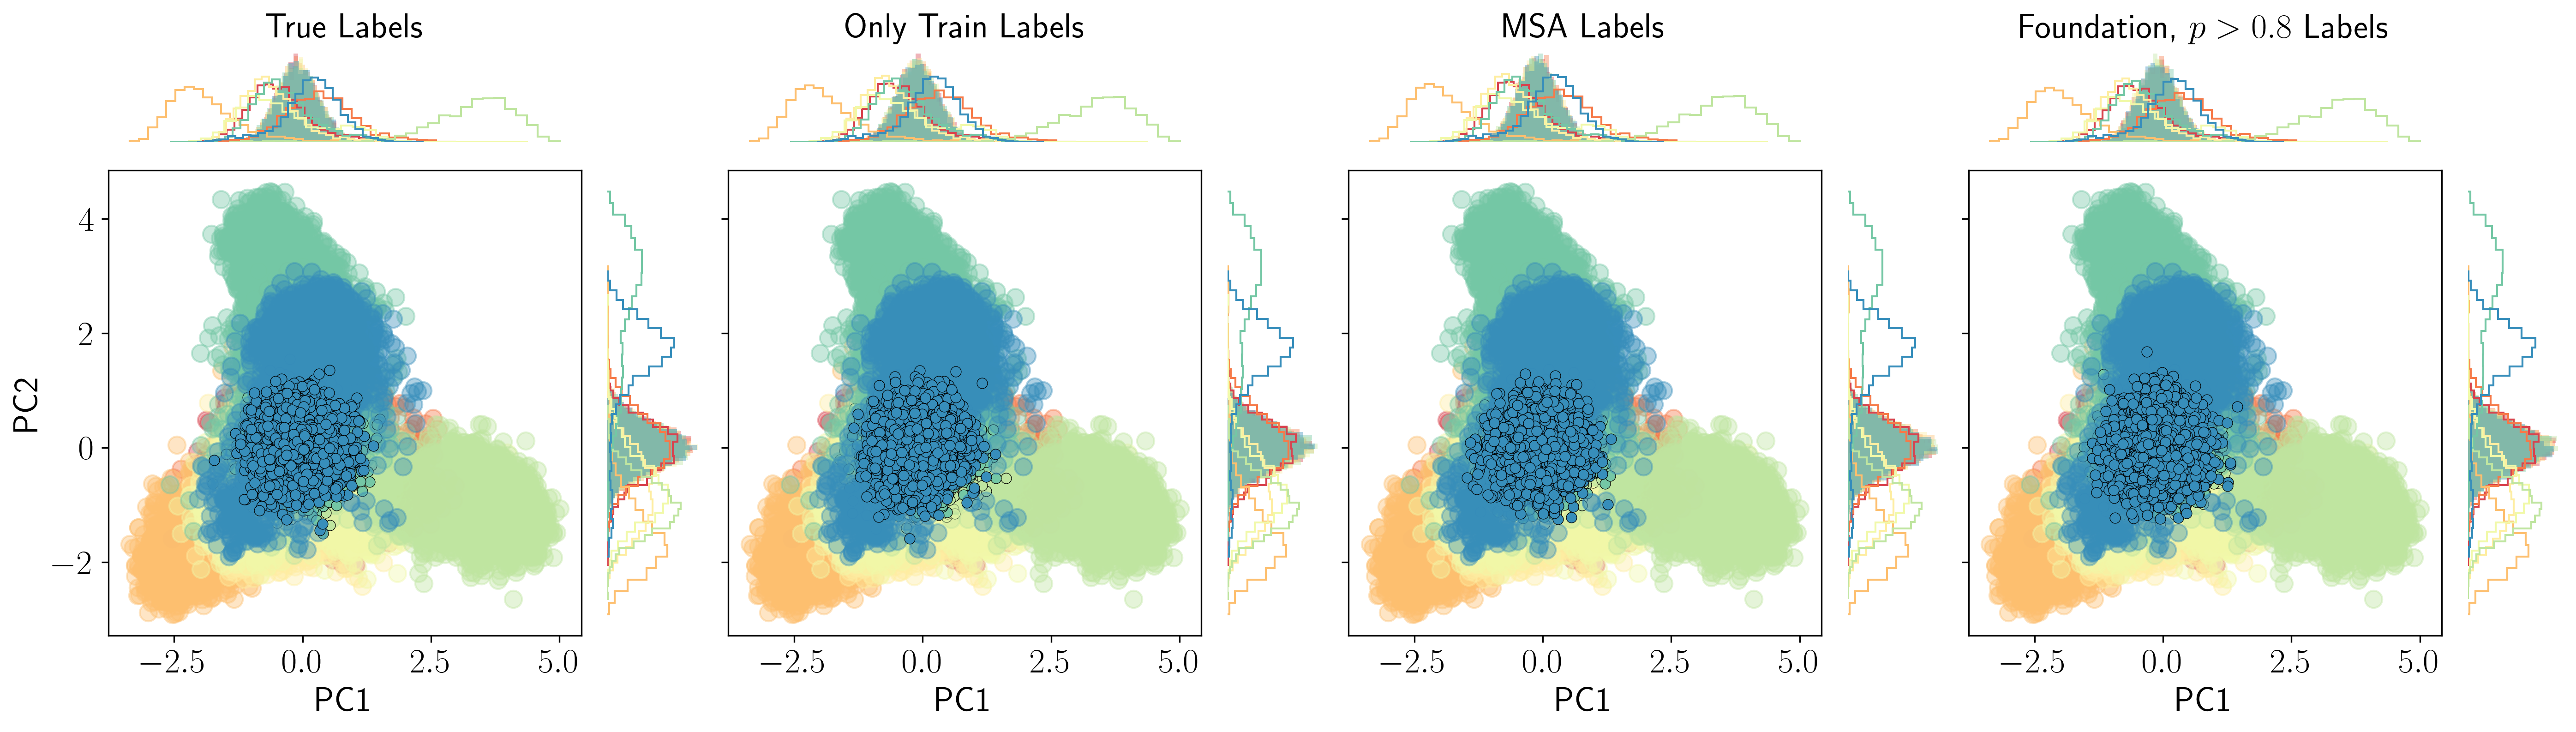

In [8]:
# use latex
plt.rcParams.update({
    "text.usetex": True,
})

fig = plt.figure(figsize=(24, 5.5), dpi=300)
gs = fig.add_gridspec(2, 9, width_ratios=[0.2, 1, 0.2, 1, 0.2, 1, 0.2, 1, 0.2], height_ratios=[0.2, 1], wspace=0.1, hspace=0.1)
colormap = sns.color_palette("Spectral", len(np.unique(y_true)))
fontsize = 18

title_map = {
    "True": "True Labels",
    "Train": "Only Train Labels",
    "MSA": "MSA Labels",
    "Foundation": r"Foundation, $p>0.8$ Labels"
}

# For each of the 4 main squares (scatter plots)
scatter_axes = []
histx_axes = []
histy_axes = []
for i in range(4):
    col = i * 2 + 1
    # Scatter plot
    ax_scatter = fig.add_subplot(gs[1, col])
    scatter_axes.append(ax_scatter)
    # Top histogram (x projection)
    ax_histx = fig.add_subplot(gs[0, col], sharex=ax_scatter)
    histx_axes.append(ax_histx)
    # Right histogram (y projection)
    ax_histy = fig.add_subplot(gs[1, col + 1], sharey=ax_scatter)
    histy_axes.append(ax_histy)

# Example plotting for the first predictor
for i, predictor in enumerate(predictors):
    # Scatter plot
    ax = plot_scatter(scatter_axes[i], data_pca, gen_pca[predictor], y_true, colormap=colormap)
    if i == 0:
        ax.set_ylabel('PC2', fontsize=fontsize)
    if i != 0:
        ax.set_yticklabels([])
    ax.set_xlabel('PC1', fontsize=fontsize)
    ax_histy = plot_hist(histy_axes[i], data_pca, gen_pca[predictor], y_true, colormap=colormap, orientation='horizontal')
    ax_histx = plot_hist(histx_axes[i], data_pca, gen_pca[predictor], y_true, colormap=colormap)
    ax_histx.set_title(title_map[predictor], fontsize=fontsize)
    ax_histx.axis('off')
    ax_histy.axis('off')
    # increase fontsize of ticks
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

plt.show()

## Test pearson of the generated sequences

In [9]:
predictors = ["True", "Train", "MSA", "Foundation", "Foundation_0.8"]

In [13]:
df_dict = {"t1": [], "predictor": [], "label": [], "pearson": []}
gibbs_steps = 1000
t1_list = [0.4, 0.7] if dataset_name == "RR" else [0.7]

for t1 in t1_list:
    print(f"Processing dataset: {dataset_name} with t1={t1}")
    
    # Load the dataset
    fname_data = f"../experiments/datasets/{dataset_name}/input-label_rbm/predictions_t1{t1}.csv"
    dataset = annaDataset(
        path_data=fname_data,
        column_sequences="sequence_align",
        column_names="header",
        column_labels="label_true",
        alphabet=tokens,
        device=device,
    )
    y_true = dataset.to_label(dataset.labels_one_hot)
    # Global statistics
    fi_all = get_freq_single_point(dataset.data_one_hot)
    fij_all = get_freq_two_points(dataset.data_one_hot)
    
    for predictor in predictors:
        print(f"---> Loading model for predictor: {predictor}")
        rbm = load_model(dataset_name, predictor, t1)
        gen = rbm.sample_conditioned(
            gibbs_steps=gibbs_steps,
            targets=dataset.labels_one_hot,
        )["visible"]
        
        # Gloal statistics for the generated data
        pi_all = get_freq_single_point(gen)
        pij_all = get_freq_two_points(gen)
        pearson_all = get_correlation_two_points(fij=fij_all, pij=pij_all, fi=fi_all, pi=pi_all)[0]
        df_dict["t1"].append(t1)
        df_dict["predictor"].append(predictor)
        df_dict["label"].append("global")
        df_dict["pearson"].append(pearson_all)
        
        for label in np.unique(y_true):
            mask = y_true == label
            fi = get_freq_single_point(dataset.data_one_hot[mask])
            fij = get_freq_two_points(dataset.data_one_hot[mask])
            pi = get_freq_single_point(gen[mask])
            pij = get_freq_two_points(gen[mask])

            df_dict["t1"].append(t1)
            df_dict["predictor"].append(predictor)
            df_dict["label"].append(label)
            df_dict["pearson"].append(get_correlation_two_points(fij=fij, pij=pij, fi=fi, pi=pi)[0])

Processing dataset: RR with t1=0.4


---> Loading model for predictor: True
---> Loading model for predictor: Train
---> Loading model for predictor: MSA
---> Loading model for predictor: Foundation
---> Loading model for predictor: Foundation_0.8
Processing dataset: RR with t1=0.7
---> Loading model for predictor: True
---> Loading model for predictor: Train
---> Loading model for predictor: MSA
---> Loading model for predictor: Foundation
---> Loading model for predictor: Foundation_0.8


/tmp/ipykernel_374010/3178404021.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(np.unique(y_true), fontsize=fontsize, rotation=20, ha='right')


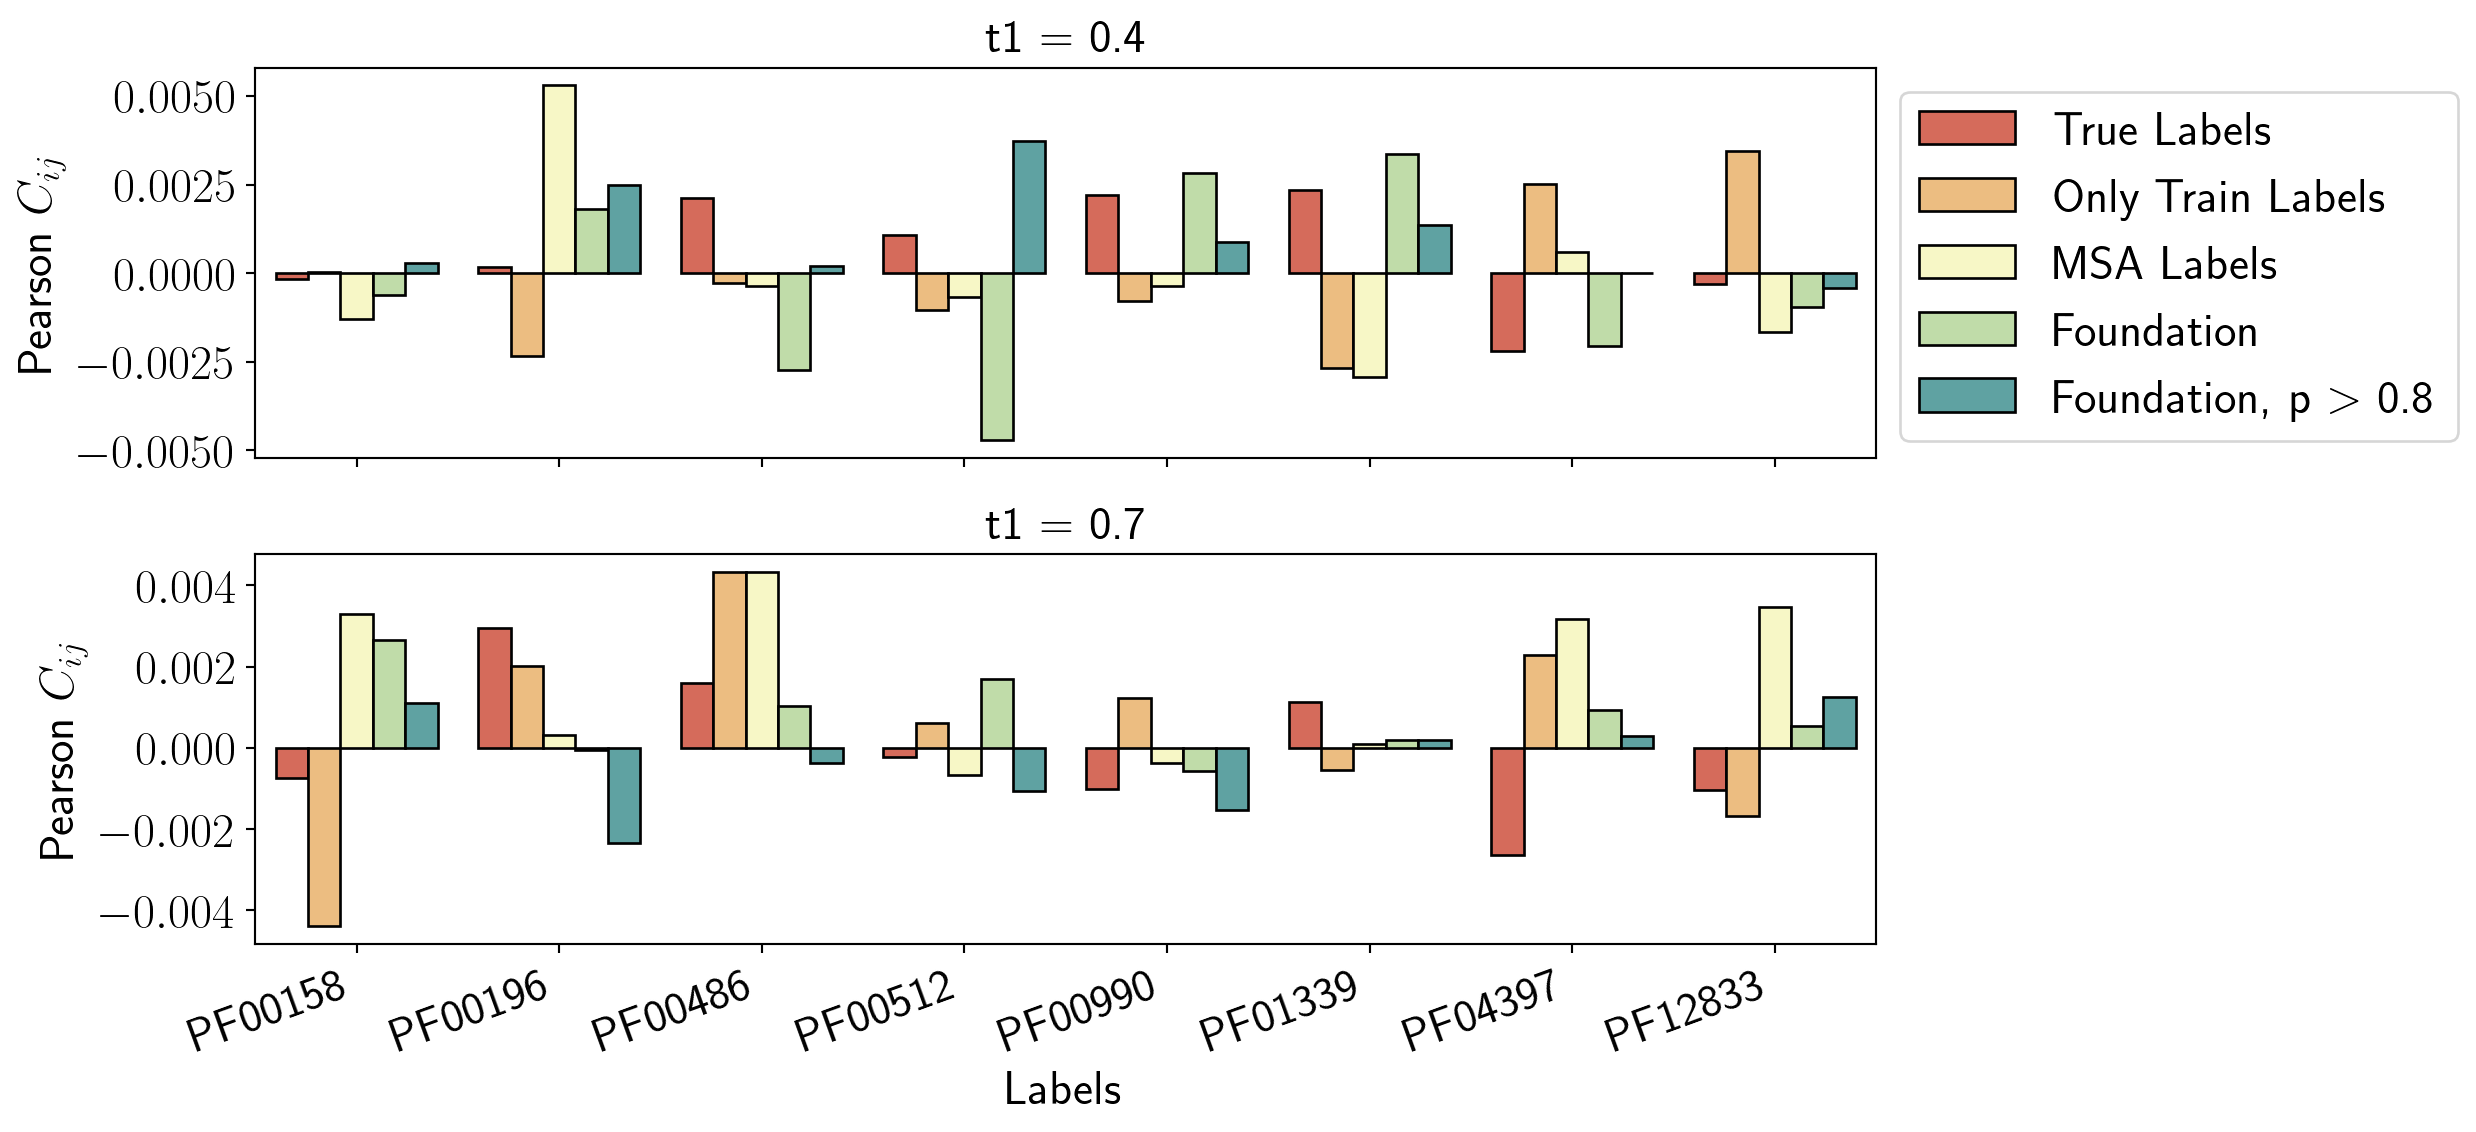

In [14]:
# barplot of the pearson correlations with error bars
df = pd.DataFrame(df_dict)
colormap = sns.color_palette("Spectral", len(predictors))

df["predictor"] = df["predictor"].replace({
    "Train": "Only Train Labels",
    "Foundation": "Foundation",
    "Foundation_0.8": r"Foundation, p $>$ 0.8",
    "True": "True Labels",
    "MSA": "MSA Labels"
})

df_labels = df[df["label"] != "global"]
df_global = df[df["label"] == "global"]

fig, ax = plt.subplots(2, 1, figsize=(13, 6), dpi=192, sharex=True)
df_t1 = df_labels[df_labels["t1"] == 0.4]
sns.barplot(
    data=df_t1,
    x="label",
    y="pearson",
    hue="predictor",
    ax=ax[0],
    palette=colormap,
    edgecolor="black",   # Add black border to bars
    linewidth=1,
)
df_t1 = df_labels[df_labels["t1"] == 0.7]
sns.barplot(
    data=df_t1,
    x="label",
    y="pearson",
    hue="predictor",
    ax=ax[1],
    palette=colormap,
    edgecolor="black",   # Add black border to bars
    linewidth=1,
)

ax[0].set_title(f"t1 = 0.4", fontsize=fontsize)
ax[1].set_title(f"t1 = 0.7", fontsize=fontsize)
ax[0].set_ylabel(r"Pearson $C_{ij}$", fontsize=fontsize)
ax[1].set_ylabel(r"Pearson $C_{ij}$", fontsize=fontsize)
ax[1].set_xlabel("Labels", fontsize=fontsize)
ax[0].legend(fontsize=fontsize, loc='upper left', bbox_to_anchor=(1, 1))
# remove legend from the second plot
ax[1].get_legend().remove()
ax[1].set_xticklabels(np.unique(y_true), fontsize=fontsize, rotation=20, ha='right')
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1].set_xlabel("Labels", fontsize=fontsize)
# add more tiks to the y axis
ax[0].yaxis.set_major_locator(plt.MaxNLocator(5))
ax[1].yaxis.set_major_locator(plt.MaxNLocator(5))

plt.tight_layout()
plt.show()

/tmp/ipykernel_374010/3054950255.py:4: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(
/tmp/ipykernel_374010/3054950255.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df_global["predictor"].unique(), fontsize=fontsize, rotation=20, ha='right')


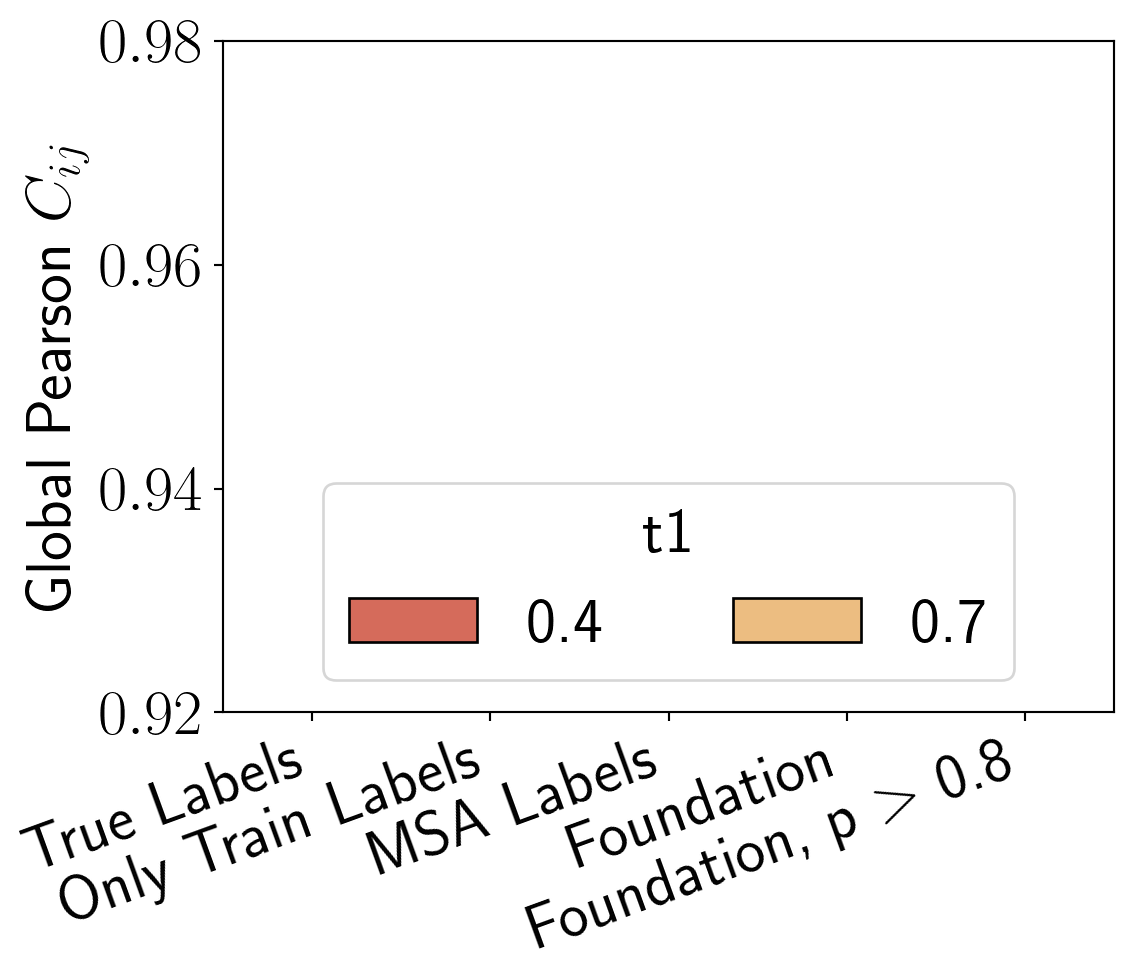

In [15]:
# small plot with the global statistics
fontsize = 24
fig, ax = plt.subplots(figsize=(6, 5.2), dpi=192)
sns.barplot(
    data=df_global,
    x="predictor",
    y="pearson",
    hue="t1",
    ax=ax,
    palette=colormap,
    edgecolor="black",   # Add black border to bars
    linewidth=1,
)
ax.set_ylabel(r"Global Pearson $C_{ij}$", fontsize=fontsize)
ax.set_xlabel("Predictors", fontsize=fontsize)
ax.set_ylim(0.92, 0.98)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.set_xticklabels(df_global["predictor"].unique(), fontsize=fontsize, rotation=20, ha='right')
ax.legend(fontsize=fontsize, title="t1", title_fontsize=fontsize, loc="lower center", ncol=2)
ax.set_xlabel("")
plt.tight_layout()
plt.show()

## Autoconsistency analysis

We generate 1000 sequences for each label using different types of label-aided RBM. We then compare the true labels with the predictions of the predictor that informed the RBM model.

### Generate sequences

In [22]:
predictors = ["True", "Train", "MSA", "Foundation"]
gibbs_steps = 1000
t1 = 0.4
# 1000 taget labels for each class
targets = []
for label in np.unique(y_true):
    targets.extend([label] * 1000)
targets_pt = dataset.to_one_hot(targets)

In [23]:
fname_dir = f"../experiments/datasets/{dataset_name}/generated-label_rbm"
if not os.path.exists(fname_dir):
    os.makedirs(fname_dir)
for predictor in predictors:
    print(f"Loading model for predictor: {predictor}")
    rbm = load_model(dataset_name, predictor, t1)
    gen = rbm.sample_conditioned(
        gibbs_steps=gibbs_steps,
        targets=targets_pt,
    )["visible"]
    
    # Save the generated sequences
    fname_gen = os.path.join(fname_dir, f"generated-{predictor.lower()}_labels-t1{t1}.csv")
    headers = [f"gen_{i}" for i in range(len(gen))]
    gen_decoded = decode_sequence(gen.argmax(-1), tokens)
    gen_decoded_unaligned = [s.replace("-", "") for s in gen_decoded]
    df_gen = pd.DataFrame({
        "header": headers,
        "sequence": gen_decoded_unaligned,
        "sequence_align": gen_decoded,
        "label": targets,
    })
    df_gen.to_csv(fname_gen, index=False)
    print(f"Generated sequences saved to {fname_gen}")

Loading model for predictor: True
Generated sequences saved to ../experiments/datasets/RR/generated-label_rbm/generated-true_labels-t10.4.csv
Loading model for predictor: Train
Generated sequences saved to ../experiments/datasets/RR/generated-label_rbm/generated-train_labels-t10.4.csv
Loading model for predictor: MSA
Generated sequences saved to ../experiments/datasets/RR/generated-label_rbm/generated-msa_labels-t10.4.csv
Loading model for predictor: Foundation
Generated sequences saved to ../experiments/datasets/RR/generated-label_rbm/generated-foundation_labels-t10.4.csv


Now, for `contrastive` and `foundation` we need to encode the generated sequences using the `pLM`. To do so, we use the appropriate python scipt

In [26]:
# run command line script to encode the generated sequences
predictors = ["True", "Train", "MSA", "Foundation"]
contrastive_checkpoint = ""
for predictor in predictors:
    if predictor.lower() == "foundation":
        command = f"python \
            ../src/pLM_encoding.py \
            --model Rostlab/prot_bert \
            --train ../experiments/datasets/{dataset_name}/t1{t1}_t20.7/train_{num_train_samples}.csv \
            --query ../experiments/datasets/{dataset_name}/generated-label_rbm/generated-{predictor.lower()}_labels-t1{t1}.csv \
            --flag predictions \
            --zero-shot \
            --bf16 \
        "
    elif predictor.lower() == "contrastive":
        command = f"python \
            ../src/pLM_encoding.py \
            --model Rostlab/prot_bert \
            --train ../experiments/datasets/{dataset_name}/t1{t1}_t20.7/train_{num_train_samples}.csv \
            --query ../experiments/datasets/{dataset_name}/generated-label_rbm/generated-{predictor.lower()}_labels-t1{t1}.csv \
            --flag predictions \
            --checkpoint {contrastive_checkpoint} \
            --bf16 \
        "
    else:
        command = f"echo 'No encoding command-line script for {predictor} predictor'"
    print(f"Running command: {command}")
    os.system(command)

Running command: echo 'No encoding command-line script for True predictor'
No encoding command-line script for True predictor
Running command: echo 'No encoding command-line script for Train predictor'
No encoding command-line script for Train predictor
Running command: echo 'No encoding command-line script for MSA predictor'
No encoding command-line script for MSA predictor
Running command: python             ../src/pLM_encoding.py             --model Rostlab/prot_bert             --train ../experiments/datasets/RR/t10.4_t20.7/train_100.csv             --query ../experiments/datasets/RR/generated-label_rbm/generated-foundation_labels-t10.4.csv             --flag predictions             --zero-shot             --bf16         
Loading dataset...
Constructed 528 positive pairs from the input dataset
Loading model...
Embedding the training dataset...


  0%|          | 0/8000 [00:00<?, ?it/s]       

Training dataset embedding saved to ../experiments/datasets/RR/t10.4_t20.7/train_100.predictions.npz
Loading the query dataset...
Embedding the query dataset...


Training a logistc regression model on the training dataset's embedding...
Predicting the query dataset's embedding...
Query dataset's embedding and predicted labels saved to ../experiments/datasets/RR/generated-label_rbm/generated-foundation_labels-t10.4.predictions.npz
Query dataset's embedding and predicted labels saved to ../experiments/datasets/RR/generated-label_rbm/generated-foundation_labels-t10.4.predictions.npz
Done!


In [34]:
# if predictor is one of "train" or "true", we directly train a logistic regression model and make predictions
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
        
for predictor in predictors:
    if predictor.lower() in ["train", "true", "msa"]:
        print(f"Training logistic regression model for predictor: {predictor}")
        fname_train = f"../experiments/datasets/{dataset_name}/t1{t1}_t20.7/train_{num_train_samples}.csv"
        fname_query = f"../experiments/datasets/{dataset_name}/generated-label_rbm/generated-{predictor.lower()}_labels-t1{t1}.csv"
        df_train = pd.read_csv(fname_train)
        df_query = pd.read_csv(fname_query)
        X_train = df_train["sequence_align"].values
        X_train = encode_sequence(X_train, tokens)
        X_train = np.eye(len(tokens))[X_train].reshape(len(X_train), -1)
        y_train = df_train["label"].values
        X_query = df_query["sequence_align"].values
        X_query = encode_sequence(X_query, tokens)
        X_query = np.eye(len(tokens))[X_query].reshape(len(X_query), -1)
        y_query = df_query["label"].values
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_query_scaled = scaler.transform(X_query)
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_query_scaled)
        y_pred_proba = model.predict_proba(X_query_scaled)
        
        # save the predictions
        np.savez_compressed(
            f"../experiments/datasets/{dataset_name}/generated-label_rbm/generated-{predictor.lower()}_labels-t1{t1}.predictions.npz",
            headers=df_query["header"].values,
            labels=y_pred,
            probs=y_pred_proba,
        )

Training logistic regression model for predictor: True


Training logistic regression model for predictor: Train
Training logistic regression model for predictor: MSA


In [35]:
def multiclass_average_roc(y_true, y_probs, classes=None):
    """
    Computes the average ROC curve and AUC score for multiclass classification.
    
    Parameters:
        y_true (array-like): True labels (shape: [n_samples])
        y_probs (array-like): Predicted probabilities (shape: [n_samples, n_classes])
        classes (array-like, optional): List of all class labels. If None, inferred from y_true.
        
    Returns:
        mean_fpr (np.ndarray): Mean false positive rates.
        mean_tpr (np.ndarray): Mean true positive rates (averaged across classes).
        mean_auc (float): Mean AUC score across classes.
    """
    if classes is None:
        classes = np.unique(y_true)
    y_true_bin = label_binarize(y_true, classes=classes)
    n_classes = len(classes)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_probs[:, i])
    
    # Interpolate all ROC curves at the same points
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    mean_auc = np.mean(list(roc_auc.values()))
    
    return all_fpr, mean_tpr, mean_auc

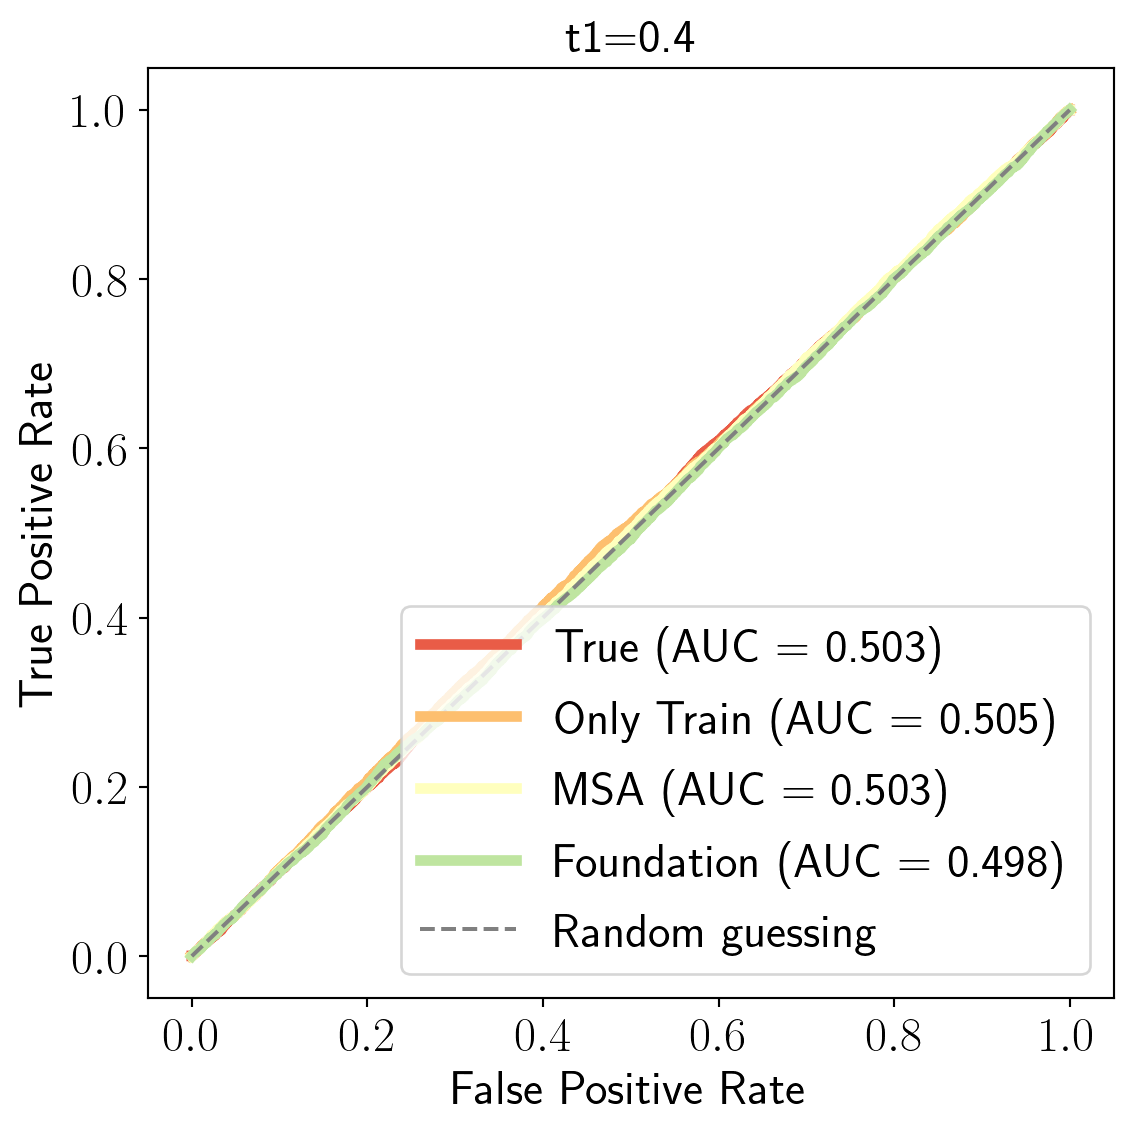

In [36]:
plt.rcParams.update({
    "text.usetex": True,
})
fontsize = 18

fig, ax = plt.subplots(figsize=(6, 6), dpi=192)
colormap = sns.color_palette("Spectral", 5)
colors = {
    "true": colormap[0],
    "msa": colormap[2],
    "foundation": colormap[3],
    "train": colormap[1],
}

t1 = 0.4
methods = ["True", "Train", "MSA", "Foundation"]
method_to_label = {
    "True": "True",
    "Train": "Only Train",
    "MSA": "MSA",
    "Foundation": "Foundation"
}
for i, method in enumerate(methods):
    fname_pred = f"../experiments/datasets/{dataset_name}/generated-label_rbm/generated-{method.lower()}_labels-t1{t1}.predictions.npz"
    fname_gen = f"../experiments/datasets/{dataset_name}/generated-label_rbm/generated-{method.lower()}_labels-t1{t1}.csv"
    df = pd.read_csv(fname_gen)
    y_true = df["label"].values
    y_scores = np.load(fname_pred)["probs"]
    color = colors[method.lower()]
    if len(np.unique(y_true)) == 2:
        fpr, tpr, roc_auc = compute_roc_curve(y_true, y_scores)
        ax.plot(fpr, tpr, color=color, label=f"{method_to_label[method]} (AUC = {roc_auc:.3f})", linewidth=4)
    else:
        fpr, tpr, roc_auc = multiclass_average_roc(y_true, y_scores)
        ax.plot(fpr, tpr, color=color, label=f"{method_to_label[method]} (AUC = {roc_auc:.3f})", linewidth=4)
        
ax.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random guessing')
ax.set_xlabel('False Positive Rate', fontsize=fontsize)
ax.set_ylabel('True Positive Rate', fontsize=fontsize)
ax.set_title(f't1={t1}', fontsize=fontsize)
ax.legend(fontsize=fontsize, loc='lower right')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tight_layout()